---
title: "Assignment 4-1"
author: "Sangwon Ju, SNU GSPA"
date: 'DEC/18/2022'
format: 
    html:
        code-overflow: wrap
        code-fold: true
categories:
   "Machine Learning & Deep Learning for Data Science (2022 Fall)" 
---

Recurrent Neural Networks (Score: 84/100)

In [1]:
import os
# get current path
print(os.getcwd())
# change path
os.chdir("E:/OneDrive - SNU\(B) 대학원/수업/2022 2학기/데이터사이언스를위한머신러닝과딥러닝/과제4/HW4")
print(os.getcwd())

e:\OneDrive - SNU\(B) 대학원\수업\2022 2학기\데이터사이언스를위한머신러닝과딥러닝\과제4\HW4
E:\OneDrive - SNU\(B) 대학원\수업\2022 2학기\데이터사이언스를위한머신러닝과딥러닝\과제4\HW4


In [ ]:
!pip install torchdata

In [2]:
%load_ext tensorboard

In [3]:
import time
import math
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

In [4]:
"""
import modules you need
"""
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 1.13.1+cpu, Device: cpu
Using torchtext version: 0.14.1


# Load Data

In [6]:
"""
Load AG_NEWS dataset and set up the tokenizer and encoder pipeline.

Do NOT modify.
"""

train_data, test_data = torchtext.datasets.AG_NEWS(root='./data')

tokenizer = get_tokenizer('basic_english')

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

encoder = build_vocab_from_iterator(tokens(train_data), specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])

text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [7]:
def collate_batch(
    batch: List[Tuple[int, str]]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Creates a batch of encoded text, label and token length tensors.

    Question (a)
    - The input texts in the batch have different lengths.
    - Complete your code to make them have same length using their average.
    - This means that the length of token sequence in each batch is determined by 
      the average of token length of all sequences in each batch.
    - Text tensors are stacked with dimension of (TOKEN_LENGTH, BATCH),
      for easier process in RNN model.
    - Token length tensors are used to index the last valid hidden token for classification.

    Args:
      batch: list of tuples, each containing an integer label and a text input.
      - ex) [(3, "Wall St. Bears..."), (4, "Comtes, Asteroids and ..."), ...]
      - number of tuples in the list is same as BATCH SIZE.

    Returns:
      text_list: batch of encoded long type text tensors with size (TOKEN_LENGTH, BATCH)
      label_list: batch of label tensors with size (BATCH)
      len_list: batch of token length tensors with size (BATCH)
    """

    ##### YOUR CODE #####
    
    text_list, label_list, len_list = [], [], []
    for (_label, _text) in batch:
        length = torch.tensor(text_pipeline(_text), dtype=torch.int64).size(0)
        len_list.append(length)
    AVG_LEN = int(sum(len_list) / len(len_list)) # bankers round 때문에 np.round 대신 사용
    
    for (_label, _text) in batch:    
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        if processed_text.size(0)>= AVG_LEN:
          processed_text = processed_text[:AVG_LEN]
        else:
          processed_text = torch.cat([processed_text,torch.zeros(AVG_LEN - processed_text.size(0))])
        text_list.append(processed_text)
        
    
    text_list = torch.stack(text_list, dim = 1).long()
    label_list = torch.tensor(label_list, dtype=torch.int64)
    len_list = torch.tensor(len_list)
    
    assert text_list.size(1) == len(batch)
    return (text_list, label_list, len_list)
    #####################

In [8]:
"""
Load the data loader.

Do NOT modify.
"""

BATCH_SIZE = 512

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

In [9]:
"""
Print out the first batch in the train loader.
Check if the collate function is implemented correctly.

Do NOT modify.
"""

batch_x, batch_y, len_x = next(iter(train_dataloader))
print(batch_x[:10])
print(batch_y[:10])
print(len_x[:10])

tensor([[  846,   472,   340,  ..., 20308,   452,  2209],
        [    3,  2188,   108,  ..., 13928,    58,    12],
        [   77,     7,   946,  ...,    20,    92,  8976],
        ...,
        [  846,    16,    58,  ...,  3468,    23,  2820],
        [ 1299,  1434,    43,  ..., 49584,    73,    10],
        [   77,   875,   294,  ...,  3212,   452,   964]])
tensor([3, 0, 2, 2, 2, 1, 0, 2, 1, 3])
tensor([40, 27, 46, 46, 37, 28, 19, 34, 35, 21])


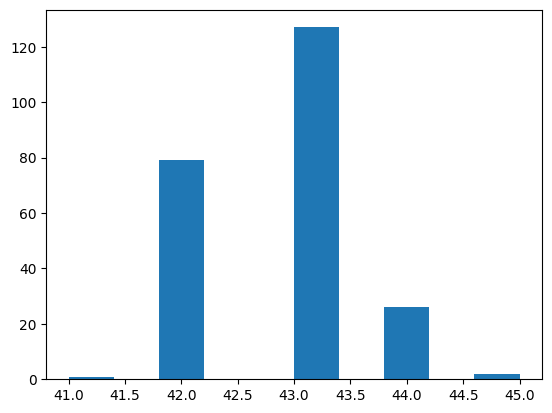

In [10]:
"""
Plot the sequence length distribution of the batches in the train dataloader.
Make sure that all batches have difference sequence lengths.

Do NOT modify.
"""

batch_len = []
for batch_x, _, _ in train_dataloader:
    seq_len = batch_x.size(0)
    batch_len.append(seq_len)
plt.hist(batch_len)
plt.show()

# Model

In [11]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        input_size: int,
        hidden_size: int,
        num_class: int,
        dropout_ratio: float,
    ):
        """
        Define the model weight parameters and initialize the weights.

        Question (b)
        - Complete the dimension and shape of the weights and biases.
        - Use the model parameters (vocab_size, input_size, hidden_size, num_class).

        Args:
          vocab_size: size of dictionary of vocabularies.
          input_size: size of each embedding vector.
          hidden_size: size of hidden dimension. 
          num_class: size of output classes.
          dropout_ratio: probability of an element to be zeroed.
        """
        super(RNN, self).__init__()

        ##### YOUR CODE #####
        whh_size = (hidden_size, hidden_size)
        wxh_size = (hidden_size, input_size)
        why_size = (num_class, hidden_size)
        bhh_size = (hidden_size ,1)
        bxh_size = (hidden_size, 1)
        bhy_size = (num_class, 1)
        #####################

        kwargs = {'device': DEVICE, 'dtype': torch.float}
        self.dropout = dropout_ratio
        self.hidden = hidden_size
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.W_hh = nn.parameter.Parameter(torch.empty(whh_size, **kwargs))
        self.W_xh = nn.parameter.Parameter(torch.empty(wxh_size, **kwargs))
        self.W_hy = nn.parameter.Parameter(torch.empty(why_size, **kwargs))
        self.b_hh = nn.parameter.Parameter(torch.empty(bhh_size, **kwargs))
        self.b_xh = nn.parameter.Parameter(torch.empty(bxh_size, **kwargs))
        self.b_hy = nn.parameter.Parameter(torch.empty(bhy_size, **kwargs))

        self.init_parameters()

    def init_parameters(self):
        """
        Initialize the parameters with Kaiming uniform initialization.

        Do NOT modify this method.
        """
        nn.init.kaiming_uniform_(self.W_hh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_xh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_xh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_xh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hy)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hy, -bound, bound)

    def forward(self, inputs: torch.Tensor, length: torch.Tensor) -> torch.Tensor:
        """
        Question (c)
        - Randomly initialize h_0 with appropriate shape.
        - Pass a sequence of tokens into the recurrent network.
        - Implement dropout to embedded tokens with the given probability (self.dropout).
          For example, if self.dropout is 0.3, 30% of the embedded tokens will be dropped out.
        - We do not want to use a hidden cell of a zero-padded token for classification!
        - Index the hidden cell of the last valid token (excluding the zero-padding)
          based on the token length of each example in the batch.
        - Do NOT use pre-defined PyTorch layers for this question. (e.g. nn.RNN, nn.Dropout)

        Args:
          inputs: a batch of encoded token sequences with shape (SEQ_LEN, BATCH_SIZE)
          length: a batch of token lengths with shape (BATCH_SIZE)
          
        Returns:
          Softmax probabilites for each class with shape (BATCH_SIZE, NUM_CLASS)
        """

        ##### YOUR CODE #####
        
        seq_len = inputs.size(0)
        batch_size = length.size(0)
        
        x_embed = self.embedding(inputs) # (seq_len, batch_size, input_size)
        
        # dropout     
        mask = (torch.rand(list(x_embed.size()))<self.dropout) / self.dropout 
        x_embed = mask * x_embed     
                    
        hiddens = [] 
        h_0 =torch.randn(self.hidden, batch_size).to(DEVICE)   
        hidden = h_0
        hiddens.append(hidden)
        
        # forward 1        
        for t in np.arange(seq_len): 
          hidden = torch.tanh((torch.matmul(self.W_hh, hidden) + self.b_xh) + 
                              (torch.matmul(self.W_xh, x_embed[t,:,:].T) + self.b_hh)).to(DEVICE)
          hiddens.append(hidden)         

        hiddens_temp = torch.zeros((self.hidden, batch_size)).to(DEVICE)      
        for i in np.arange(batch_size):
          if length[i] < seq_len:
            hidden_length = hiddens[int(length[i])]
            hiddens_temp[:,i] = hidden_length[:,i]
          else:
            hidden_length = hiddens[seq_len]
            hiddens_temp[:,i] = hidden_length[:,i]   
            
        # Y_pred           
        softmax = nn.Softmax(dim=0)
        softmax_probs = softmax(torch.matmul(self.W_hy, hiddens_temp) + self.b_hy).permute(1,0)
        
        return softmax_probs 
        #####################

    def compute_loss(
        self,
        prediction: torch.Tensor, 
        label: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """
        Question (d)
        - Compute the cross entropy loss and the number of correct predictions
        - Do NOT use loss function in torch.nn library (e.g. nn.CrossEntropyLoss())

        Args:
          prediction: output(softmax probabilities) from self.forward function with shape (BATCH_SIZE, NUM_CLASS)
          label: integer labels of the batch inputs with shape (BATCH_SIZE)
        
        Returns:
          cross entropy loss of the batch (float tensor) and the number of correct predictions (integer)
        """

        ##### YOUR CODE #####
        loss = 0
        correct = 0
        
        batch_size = label.size(0)
                
        label_enc = F.one_hot(label, self.num_class)
        label_enc = label_enc.to(DEVICE)

        loss = - torch.sum(label_enc * torch.log(prediction))
        correct = int((label == prediction.argmax(1)).sum())
        loss /= batch_size 
        
        return (loss, correct)
        #####################

# Training Modules

In [12]:
class ScheduledOptim():
    """
    Learning rate scheduler.

    Do NOT modify.
    """

    def __init__(self, optimizer, n_warmup_steps, decay_rate):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()
    
    def step(self):
        self._optimizer.step()
    
    def get_lr(self):
        return self.current_lr
    
    def update(self):
        if self.n_steps < self.n_warmup_steps:
            lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
            lr = self.initial_lr
        else:
            lr = self.current_lr * self.decay
        
        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

        self.n_steps += 1

In [13]:
"""
Functions for training and evaluating the model.

Question (e)
- There has been minor changes with the model forward operation and loss computation.
  Check what has been changed from the train and evaluate functions that we have used previously,
  and complete the train and evaluate function that works for the current model architecture.
- Use the methods of the ScheduledOptim class above to perform necessary operations on the optimizer.
- Do NOT change the arguments given to the train, evaluate functions.
"""

def train(model, train_loader, scheduler):
    ##### YOUR CODE #####
    model.train()
    train_loss = 0
    correct = 0

    tqdm_bar = tqdm(train_loader)

    for text, label, length in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        length = length.to(DEVICE)
                
        scheduler.zero_grad()        
        class_pred = model(text, length)
        loss_temp, correct_temp = model.compute_loss(class_pred, label)
        loss_temp.backward()
        scheduler.step()
        train_loss += loss_temp
        correct += correct_temp 
    
    scheduler.update()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)

    return train_loss, train_acc
    #####################


def evaluate(model, test_loader):
    ##### YOUR CODE #####
    model.eval()
    test_loss = 0
    correct = 0

    tqdm_bar = tqdm(test_loader)

    with torch.no_grad():
        for text, label, length in tqdm_bar:
            text = text.to(DEVICE)
            label = label.to(DEVICE)
            length = length.to(DEVICE)
    
            class_pred = model(text, length)
            loss_temp, correct_temp = model.compute_loss(class_pred, label) 
            test_loss += loss_temp
            correct += correct_temp         

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    return test_loss, test_acc
    #####################

# Model Training

In [23]:
"""
Question (f)
- Train your RNN model and obtain the test accuracy of 70%.
- Select the input size, hidden size of your choice
- Try various optimizer type, learning rate and scheduler options for the best performance.
- Visualize your experiments with Tensorboard.
- Your TensorBoard results should include Train/Validation Loss and Accuracy.
"""

##### YOUR CODE #####
writer = SummaryWriter(log_dir="./logs")
EPOCHS = 15
BATCH_SIZE = 512
vocab_size = len(encoder) # 95811
input_size = 45
hidden_size = 128
num_class = 4
dropout_ratio = 0.3
learning_rate = 0.001

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

model = RNN(vocab_size, input_size, hidden_size, num_class,dropout_ratio)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ScheduledOptim(optimizer, 5, 0.8)

for epoch in range(1, EPOCHS + 1):
    loss_train, accu_train = train(model, train_dataloader, scheduler)
    writer.add_scalar("Loss/train", loss_train,epoch)
    writer.add_scalar("Accuracy/train", accu_train,epoch)
    loss_val, accu_val = evaluate(model, valid_dataloader)
    writer.add_scalar("Loss/test", loss_val,epoch)
    writer.add_scalar("Accuracy/test", accu_val,epoch)

    lr = scheduler.get_lr()
    print('-' * 83)
    print('| end of epoch {:2d} | lr: {:5.4f} | train loss: {:8.3f} | train accuracy: {:8.3f} | '
          'valid accuracy {:8.3f} '.format(epoch, lr, loss_train, accu_train, accu_val))
    print('-' * 83)

writer.flush()
writer.close()
#####################

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  1 | lr: 0.0000 | train loss:    0.003 | train accuracy:   34.801 | valid accuracy   43.211 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  2 | lr: 0.0002 | train loss:    0.002 | train accuracy:   42.688 | valid accuracy   43.171 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  3 | lr: 0.0004 | train loss:    0.002 | train accuracy:   44.939 | valid accuracy   46.316 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  4 | lr: 0.0006 | train loss:    0.002 | train accuracy:   49.015 | valid accuracy   50.842 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  5 | lr: 0.0008 | train loss:    0.002 | train accuracy:   54.191 | valid accuracy   56.053 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  6 | lr: 0.0010 | train loss:    0.002 | train accuracy:   59.338 | valid accuracy   61.447 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  7 | lr: 0.0008 | train loss:    0.002 | train accuracy:   64.619 | valid accuracy   67.066 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  8 | lr: 0.0006 | train loss:    0.001 | train accuracy:   69.592 | valid accuracy   72.197 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  9 | lr: 0.0005 | train loss:    0.001 | train accuracy:   73.544 | valid accuracy   72.592 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 10 | lr: 0.0004 | train loss:    0.001 | train accuracy:   75.653 | valid accuracy   74.908 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 11 | lr: 0.0003 | train loss:    0.001 | train accuracy:   77.224 | valid accuracy   76.961 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 12 | lr: 0.0003 | train loss:    0.001 | train accuracy:   78.388 | valid accuracy   77.250 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 13 | lr: 0.0002 | train loss:    0.001 | train accuracy:   79.117 | valid accuracy   78.066 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 14 | lr: 0.0002 | train loss:    0.001 | train accuracy:   79.552 | valid accuracy   78.882 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 15 | lr: 0.0001 | train loss:    0.001 | train accuracy:   79.949 | valid accuracy   79.342 
-----------------------------------------------------------------------------------


In [27]:
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 20996), started 1 day, 0:41:02 ago. (Use '!kill 20996' to kill it.)

In [25]:
# Run this cell to upload the result to TensorBoard.dev
# Then you will get the shared link.

# tensorboard dev upload --logdir 'e:\OneDrive - SNU\(B) 대학원\수업\2022 2학기\데이터사이언스를위한머신러닝과딥러닝\과제4\HW4' --name "MLDL1 HW4" --description "Training results from HW4 RNN Problem" --one_shot

In [26]:
# Write down the shared link in the below cell.

Write down the TensorBoard link in this cell.

https://tensorboard.dev/experiment/1816CBEmQJm0J3ZCKYEE6A/